C:\Users\severin\AppData\Local\Temp\ipykernel_25356\4018244493.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])
C:\Users\severin\AppData\Local\Temp\ipykernel_25356\4018244493.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])


utm_campaign  advanced_algorithms_series  intro_to_python_course  none  \
month                                                                    
2023-03                            14706                       0  5022   
2023-04                                0                       0     0   
2023-05                                0                       0  6482   
2023-06                                0                       0  5683   
2023-07                                0                       0  2794   
2023-08                                0                   22917  2975   

utm_campaign  ui_ux_design_drive  virtual_reality_workshop  \
month                                                        
2023-03                        0                      4189   
2023-04                        0                     24172   
2023-05                     8333                      4337   
2023-06                     6065                         0   
2023-07                        0   

C:\Users\severin\AppData\Local\Temp\ipykernel_25356\4018244493.py:150: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_ads = pd.pivot_table(


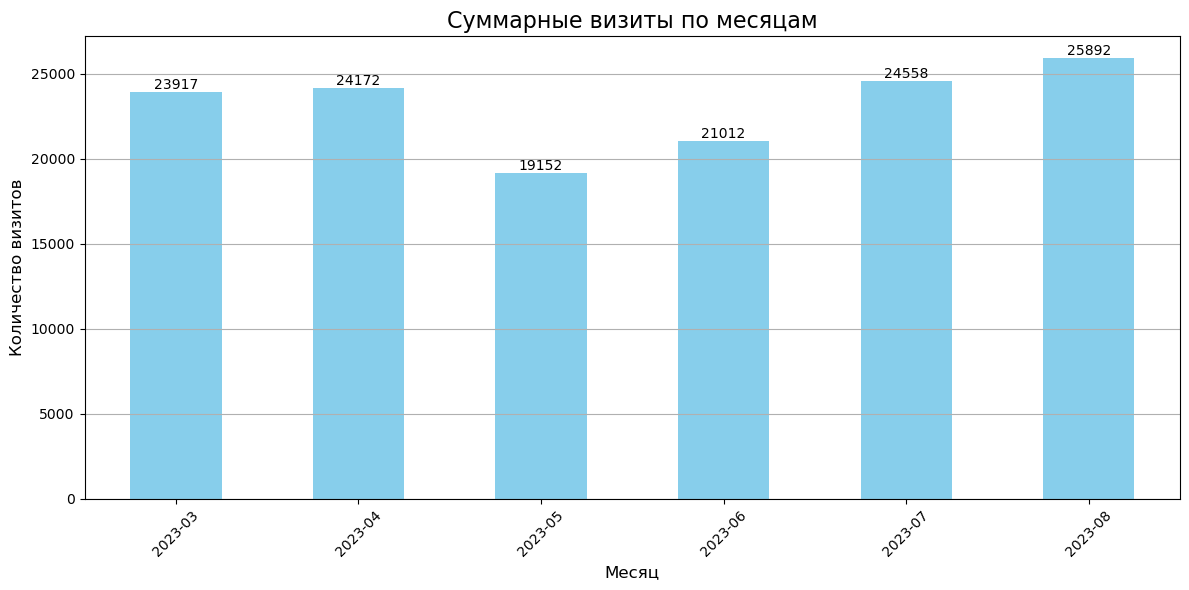

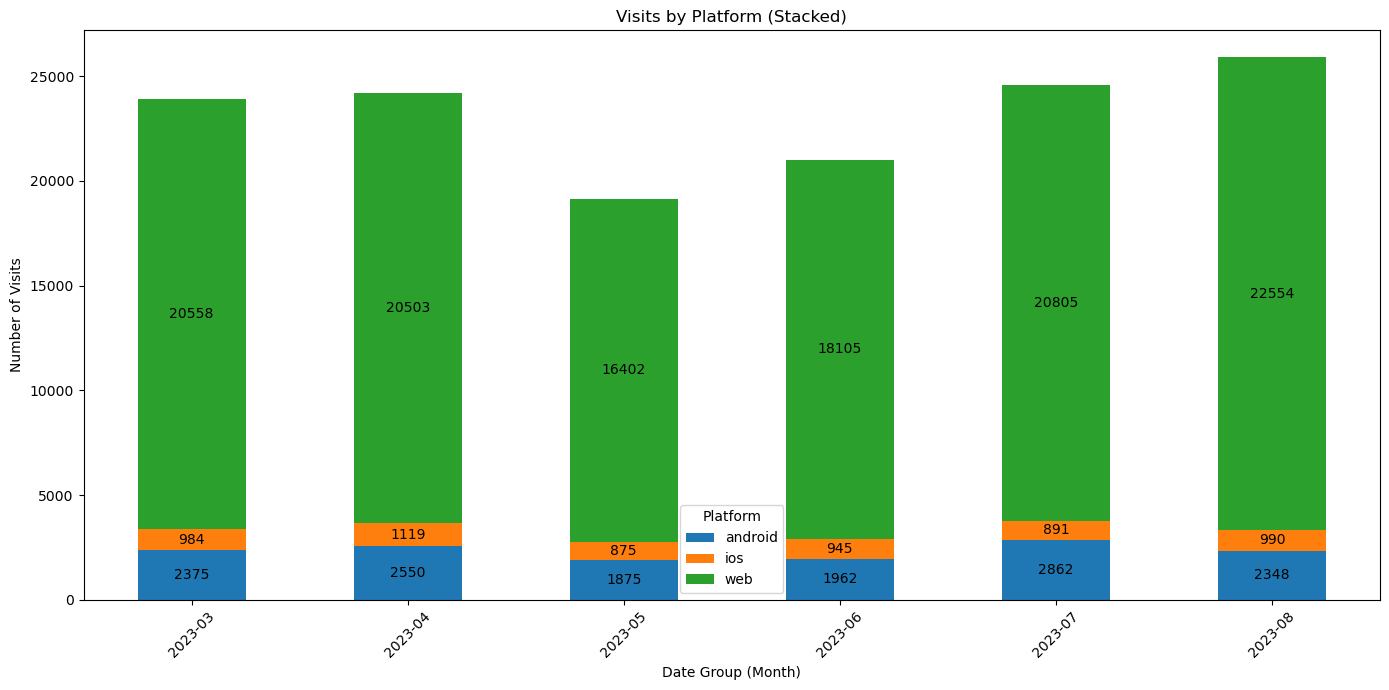

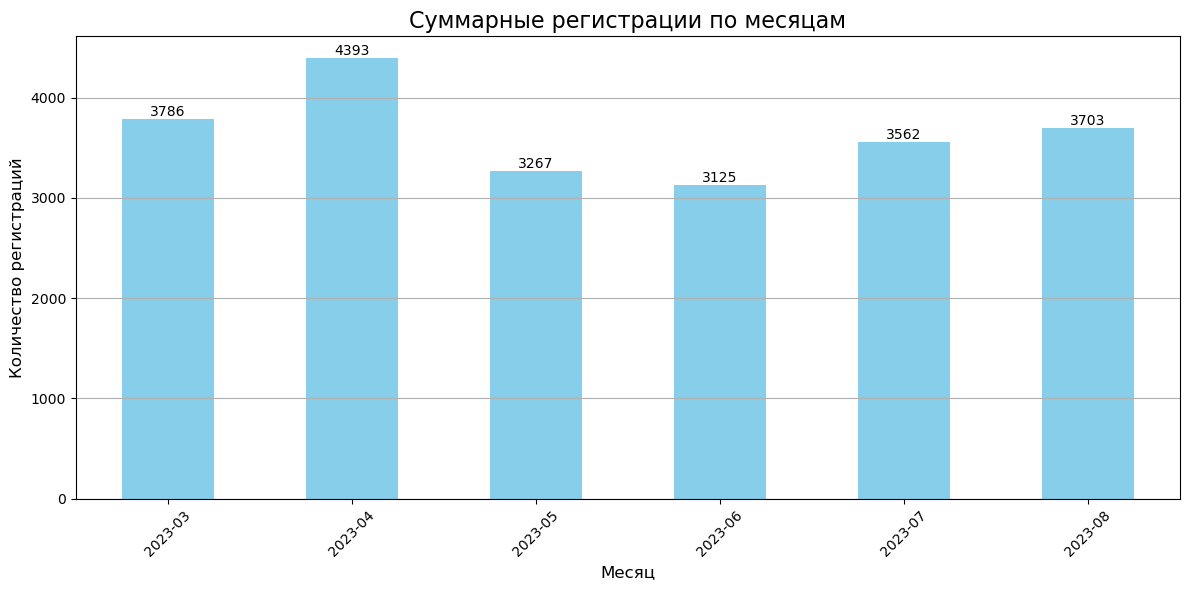

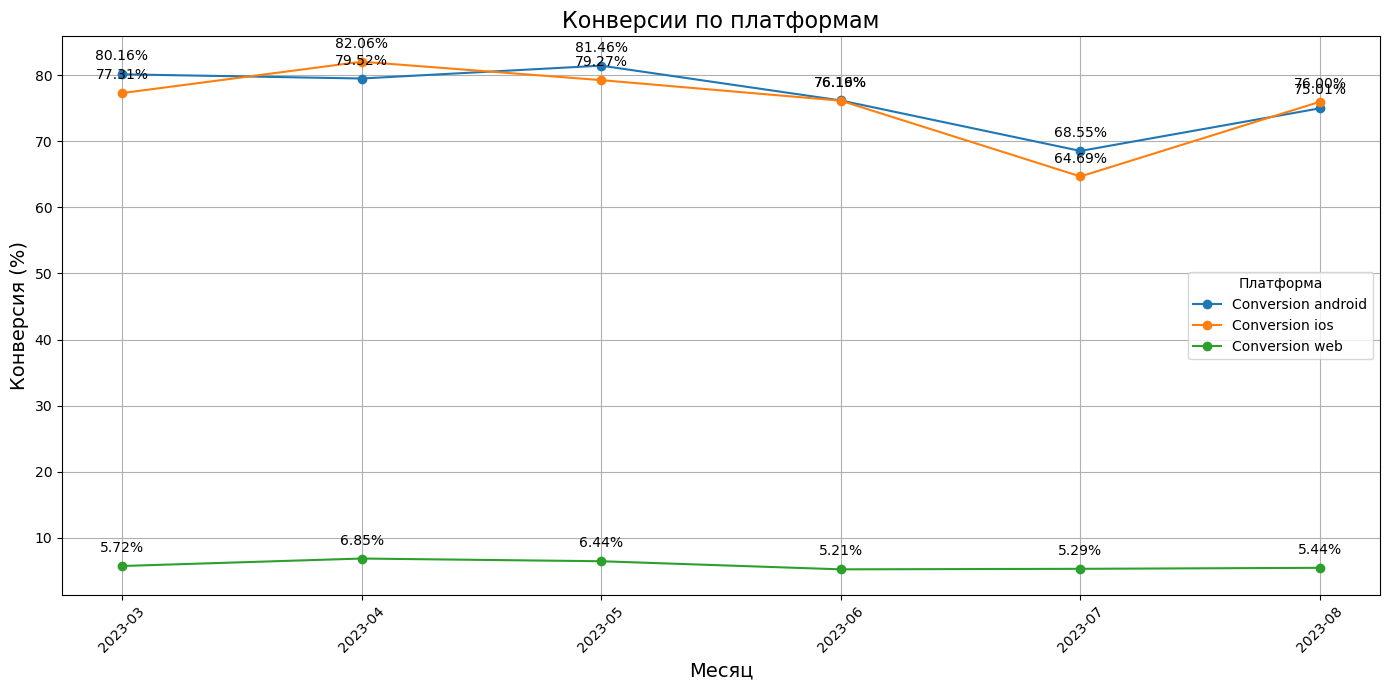

<Figure size 1400x700 with 0 Axes>

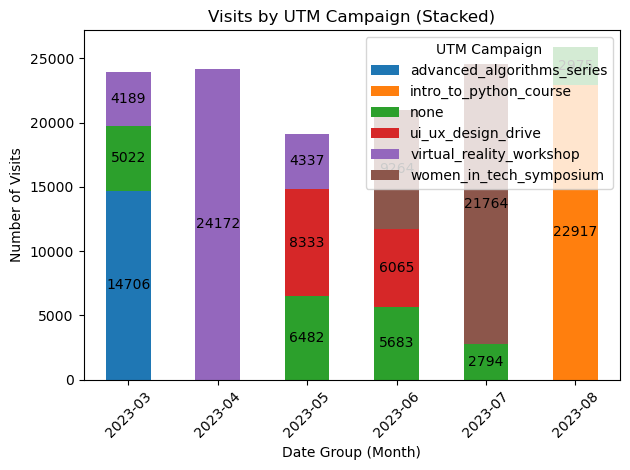

<Figure size 1400x700 with 0 Axes>

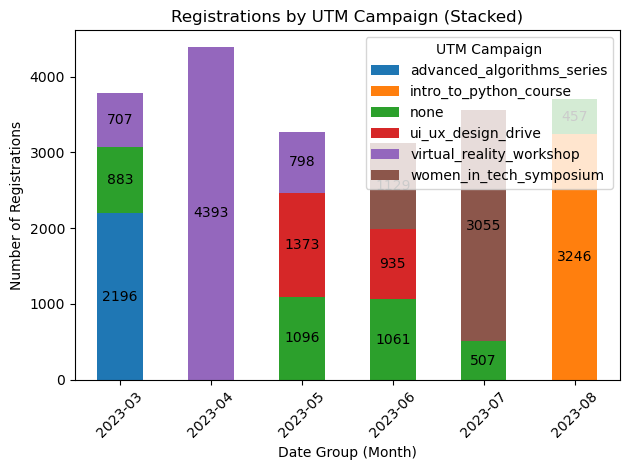

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U108')) -> None

<Figure size 1400x700 with 0 Axes>

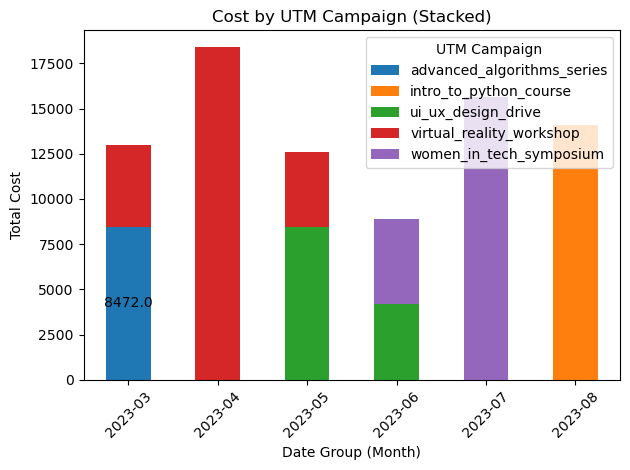

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv

# Создаем директорию для графиков, если она не существует
os.makedirs("charts", exist_ok=True)
load_dotenv()

    # Получаем даты из переменных окружения
start_date = os.getenv("DATE_BEGIN")
end_date = os.getenv("DATE_END")
api_url = os.getenv("API_URL")

    # Делаем две ссылки
visit_url = f"{api_url}/visits?begin={start_date}&end={end_date}"
reg_url = f"{api_url}/registrations?begin={start_date}&end={end_date}"

def summary_fun():
    df_regs = pd.read_csv("regs_1k.csv")
    df_visits = pd.read_csv("visits_1k.csv")

    summary_regs = df_regs.describe()
    summary_visits = df_visits.describe()
    return summary_regs, summary_visits


def conversion_fun():
    # Загружаем переменные окружения из файла .env
  

    # Теперь тянем визиты и регистрации
    visits = requests.get(visit_url)
    registrations = requests.get(reg_url)

    # Получаем данные в формате JSON
    visits = visits.json()
    registrations = registrations.json()

    # Конвертируем в датафрейм
    registrations = pd.DataFrame(registrations)
    visits = pd.DataFrame(visits)

    # Убираем ботов
    filtered_visits = visits[
        ~visits["user_agent"].str.contains("bot", case=False, na=False)
    ]

    # Конвертируем в дату
    filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])
    registrations["datetime"] = pd.to_datetime(registrations["datetime"])

    # Сортируем и берем последний визит
    filtered_visits = filtered_visits.sort_values(by=["visit_id", "datetime"])
    last_visit = filtered_visits.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset=['visit_id'], keep='last')
    #last_visit = filtered_visits.sort_values('datetime').drop_duplicates('visit_id', keep='last')

    # Группируем по датам и платформам
    last_visit["date_group"] = last_visit["datetime"].dt.date
    df_visit = (
        last_visit.groupby(["platform", "date_group"]).size().reset_index(name="visits")
    )

    # Регистрации по датам и платформам
    registrations["date_group"] = registrations["datetime"].dt.date
    df_reg = (
        registrations.groupby(["platform", "date_group"])
        .size()
        .reset_index(name="registrations")
    )

    # Объединяем и вычисляем конверсию
    df_conversion = pd.merge(df_visit, df_reg, on=["platform", "date_group"])
    df_conversion["conversion"] = 100 * df_conversion["registrations"] / df_conversion["visits"].replace(0, np.nan)    
    df_conversion = df_conversion[["date_group", "platform", "visits", "registrations", "conversion"]]
    df_conversion = df_conversion.sort_values(by=["date_group"])
    df_conversion.reset_index(drop=True, inplace=True)

    # Сохраняем в JSON
    df_conversion.to_json("./conversion.json")
    df_conversion.to_excel("./conversion(my).xlsx")

    return df_conversion
    
conversion_fun()
df_conversion = conversion_fun()


def process_ad_data():
    # Загружаем данные о компаниях и конверсии
    df_company = pd.read_csv("ads.csv")

    # Преобразуем данные о компаниях
    df_company["date"] = pd.to_datetime(df_company["date"])
    df_company["date_group"] = df_company["date"].dt.date
# дропнуть дубликаты
    df_company.drop_duplicates(inplace=True)
#добавить фильтр по датам из env
    start_date = pd.to_datetime(os.getenv("DATE_BEGIN")).date()
    end_date = pd.to_datetime(os.getenv("DATE_END")).date()
    df_company = df_company[(df_company["date_group"] >= start_date) & (df_company["date_group"] <= end_date)]
    # Группируем данные по кампании и дате
    df_company = df_company.groupby(["date_group", "utm_campaign"], as_index=False)[
        "cost"
    ].sum() 

    # Преобразуем дату в данных о конверсии
    df_conversion["date_group"] = pd.to_datetime(df_conversion["date_group"]).dt.date

    # Объединяем данные о компаниях и конверсии
    ads = pd.merge(df_conversion, df_company, on=["date_group"], how="left").fillna("none")

    # Определяем порядок колонок
    ads = ads[["date_group", "visits", "registrations", "cost", "utm_campaign"]]
    ads = ads.reset_index(drop=True).sort_values(by=["date_group"])

    # Сохраняем итоговые данные в JSON
    ads.to_json("./ads.json")

    return ads
    
process_ad_data()

# Загружаем все источники

conversion = df_conversion
ads = process_ad_data()
# Готовим данные для conversion
conversion["date_group"] = pd.to_datetime(conversion["date_group"])
conversion["month"] = conversion["date_group"].dt.to_period("M")

# Готовим данные для ads
ads["date_group"] = pd.to_datetime(ads["date_group"])
ads["month"] = ads["date_group"].dt.to_period("M")

# Создаем сводную таблицу
pivot_conversion = pd.pivot_table(
    conversion,
    index="month",
    columns="platform",
    values=["visits", "registrations", "conversion"],
    aggfunc={"visits": "sum", "registrations": "sum", "conversion": "mean"},
    fill_value=0,
)

pivot_ads = pd.pivot_table(
    ads,
    index="month",
    columns="utm_campaign",
    values=["visits", "registrations", "cost"],
    aggfunc="sum",
    fill_value=0,
)

# Подсчитываем суммарные визиты и регистрации по месяцам
total_visits = pivot_conversion["visits"].sum(axis=1)
total_regs = pivot_conversion["registrations"].sum(axis=1)
total_convers = pivot_conversion["conversion"]

print(pivot_ads["visits"])

# Функция для построения графика визитов по месяцам
def plot_total_visits():
    plt.figure(figsize=(12, 6))
    bars = total_visits.plot(kind="bar", color="skyblue")
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval, int(yval), va="bottom", ha="center"
        )
    plt.title("Суммарные визиты по месяцам", fontsize=16)
    plt.xlabel("Месяц", fontsize=12)
    plt.ylabel("Количество визитов", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig("./charts/total_visits_per_month.png")
    plt.show()


# Функция для построения графика посещений в разрезе площадок
def plot_visits_by_platform():
    ax = pivot_conversion["visits"].plot(kind="bar", stacked=True, figsize=(14, 7))
    plt.title("Visits by Platform (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Number of Visits")
    plt.xticks(rotation=45)
    plt.legend(title="Platform")
    plt.tight_layout()
    for i in range(pivot_conversion["visits"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_conversion["visits"].shape[1]):
            value = pivot_conversion["visits"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/visits_by_platform.png")
    plt.show()


# Функция для построения графика регистраций по месяцам
def plot_total_regs():
    plt.figure(figsize=(12, 6))
    bars = total_regs.plot(kind="bar", color="skyblue")
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval, int(yval), va="bottom", ha="center"
        )
    plt.title("Суммарные регистрации по месяцам", fontsize=16)
    plt.xlabel("Месяц", fontsize=12)
    plt.ylabel("Количество регистраций", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig("./charts/total_regs_per_month.png")
    plt.show()


# Функция для построения графика конверсий по платформам
def plot_conversion_by_platform():
    plt.figure(figsize=(14, 7))
    for platform in pivot_conversion["conversion"].columns:
        plt.plot(
            total_convers.index.astype(str),
            total_convers[platform],
            marker="o",
            linestyle="-",
            label=f"Conversion {platform}",
        )
        for i, val in enumerate(total_convers[platform]):
            plt.annotate(
                f"{val:.2f}%",
                (
                    total_convers.index[i].strftime("%Y-%m"),
                    total_convers[platform].iloc[i],
                ),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
            )
    plt.title("Конверсии по платформам", fontsize=16)
    plt.xlabel("Месяц", fontsize=14)
    plt.ylabel("Конверсия (%)", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Платформа")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("./charts/conversion_by_platform.png")
    plt.show()


def plot_ads_visits():
    plt.figure(figsize=(14, 7))
    ax = pivot_ads["visits"].plot(kind="bar", stacked=True)
    plt.title("Visits by UTM Campaign (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Number of Visits")
    plt.xticks(rotation=45)
    plt.legend(title="UTM Campaign")
    plt.tight_layout()
    for i in range(pivot_ads["visits"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_ads["visits"].shape[1]):
            value = pivot_ads["visits"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/ads_visits_by_campaign.png")
    plt.show()


# Функция для построения графика регистраций по рекламным кампаниям (stacked)
def plot_ads_regs():
    plt.figure(figsize=(14, 7))
    ax = pivot_ads["registrations"].plot(kind="bar", stacked=True)
    plt.title("Registrations by UTM Campaign (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Number of Registrations")
    plt.xticks(rotation=45)
    plt.legend(title="UTM Campaign")
    plt.tight_layout()
    for i in range(pivot_ads["registrations"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_ads["registrations"].shape[1]):
            value = pivot_ads["registrations"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/ads_regs_by_campaign.png")
    plt.show()


# Функция для построения графика затрат по рекламным кампаниям (stacked)
def plot_ads_cost():
    plt.figure(figsize=(14, 7))
    ax = pivot_ads["cost"].plot(kind="bar", stacked=True)
    plt.title("Cost by UTM Campaign (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Total Cost")
    plt.xticks(rotation=45)
    plt.legend(title="UTM Campaign")
    plt.tight_layout()
    for i in range(pivot_ads["cost"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_ads["cost"].shape[1]):
            value = pivot_ads["cost"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/ads_cost_by_campaign.png")
    plt.show()


def plot_conversion_stats(month="2023-07"):
    global conversion  # Ссылаемся на глобальную переменную
    # Фильтруем данные по выбранному месяцу
    filtered_conversion = conversion[conversion["month"] == month]

    # Создаем сводную таблицу
    daily_conversion = pd.pivot_table(
        filtered_conversion,
        index="date_group",
        columns="platform",
        values=["visits", "registrations", "conversion"],
        aggfunc={"visits": "sum", "registrations": "sum", "conversion": "mean"},
        fill_value=0,
    )

    # Получаем отдельные данные для графиков
    visits = daily_conversion["visits"]
    registrations = daily_conversion["registrations"]
    conversion_data = daily_conversion["conversion"]  # Переименуем переменную

    # Настраиваем графики
    plt.figure(figsize=(15, 10))

    # График визитов
    plt.subplot(3, 1, 1)
    for platform in visits.columns:
        plt.plot(visits.index, visits[platform], label=platform)
        for x, y in zip(visits.index, visits[platform]):
            plt.text(x, y, str(y), fontsize=8, ha="right")  # Подписи на графике
    plt.title("Визиты по платформам")
    plt.ylabel("Количество визитов")
    plt.legend()
    plt.grid()

    # График регистраций
    plt.subplot(3, 1, 2)
    for platform in registrations.columns:
        plt.plot(registrations.index, registrations[platform], label=platform)
        for x, y in zip(registrations.index, registrations[platform]):
            plt.text(x, y, str(y), fontsize=8, ha="right")  # Подписи на графике
    plt.title("Регистрации по платформам")
    plt.ylabel("Количество регистраций")
    plt.legend()
    plt.grid()

    # График конверсий
    plt.subplot(3, 1, 3)
    for platform in conversion_data.columns:  # Используем новое имя переменной
        plt.plot(conversion_data.index, conversion_data[platform], label=platform)
        for x, y in zip(conversion_data.index, conversion_data[platform]):
            plt.text(x, y, f"{y:.2f}", fontsize=8, ha="right")  # Подписи на графике
    plt.title("Конверсии по платформам")
    plt.ylabel("Средняя конверсия")
    plt.legend()
    plt.grid()

    plt.tight_layout()

    # Сохранение графика
    plt.savefig("./charts/conversion_stats_" + month.replace("-", "") + ".png")

    # Показ графика
    plt.show()

plot_total_visits()
plot_visits_by_platform()
plot_total_regs()
plot_conversion_by_platform()
plot_ads_visits()
plot_ads_regs()
plot_ads_cost()
plot_conversion_stats("2023-07")
